# Hackathon Project 🔥🔥
## Recruit Restaurant Visitor Forecasting
## Table of Contents
1. Problem Definition
2. Preprocessing
3. EDA
    - Missing value check
    - Outlier Detection
    - Correlation
    - Time Series Data Visualization
    - Categorical Variable Encoding
    - Geographic information
3. Model Training
4. Model Evaluation & Summary
5. Retrospective

## 1. Problem Definition
----------------------------------

### 배경

1. 날씨, 주변 경쟁업체 등 예측할 수 없는 많은 요인으로 예상 고객 수를 판단하기가 어려움
2. 이로 인해 재료를 얼마나 구매하고 직원을 어떻게 고용할지는 예상 고객 수에 따라 판단될 수 있어 레스토랑을 효과적으로 운영하기 위해 방문율을 예측하는 것이 중요

### 가설 및 검증

1. 000으로 인해 레스토랑을 이용하는 고객이 증가(또는 감소) 추세에 있을 것이다.
2. 검증 세분화
    1. 주요 시간대
        1. 증가
        2. 감소
    2. 공휴일 여부
        1. 공휴일
        2. 평일
    3. 시스템
        1. air
        2. hpg
3. 분석을 통해 얻는 것
    1. 추세를 파악할 수 있다.
        1. 늘어난다면, 수요에 대비할 수 있다.
        2. 줄어든다면, 서비스를 개선하거나 사업 계획을 정비한다.
        3. 주기에 따라 맞춤형 경영을 할 수 있다

### 데이터 현황

1. Hot Pepper Gourmet(레스토랑 리뷰 서비스) : 레스토랑을 검색하고 온라인으로 예약
2. AirREGI(레스토랑 POS 서비스) : 예약 제어 및 금전 등록 시스템
3. 레스토랑 보드 : 예약 로그 관리 소프트웨어
4. 기타
    1. 훈련 데이터는 2016년부터 2017년 4월까지의 날짜를 포함
    2. 테스트 세트는 2017년 4월과 5월의 마지막 주를 포함
    3. 테스트 세트는 시간을 기준으로 분할(공개 폴드가 먼저, 비공개 폴드가 공개 다음에 옴) → **보류**
    4. 테스트 세트는 의도적으로 "골든 위크"라고 불리는 일본의 휴일 주간에 걸쳐 있음 → **손님이 많을 것이다**
    5. 테스트 세트에는 레스토랑이 문을 닫고 방문자가 없는 날이 있었습니다. 스코어링 시 무시됩니다. 훈련 세트는 레스토랑이 문을 닫는 날을 생략 → **휴일 + 방문자수가 없으면 문을 닫은 날로 판단**
    6. 각 레스토랑은 고유 air_store_id하고 hpg_store_id. 모든 레스토랑이 두 시스템 모두에 적용되는 것은 아니며 예측해야 하는 레스토랑 이외의 데이터가 제공됌 → **air만 분석**

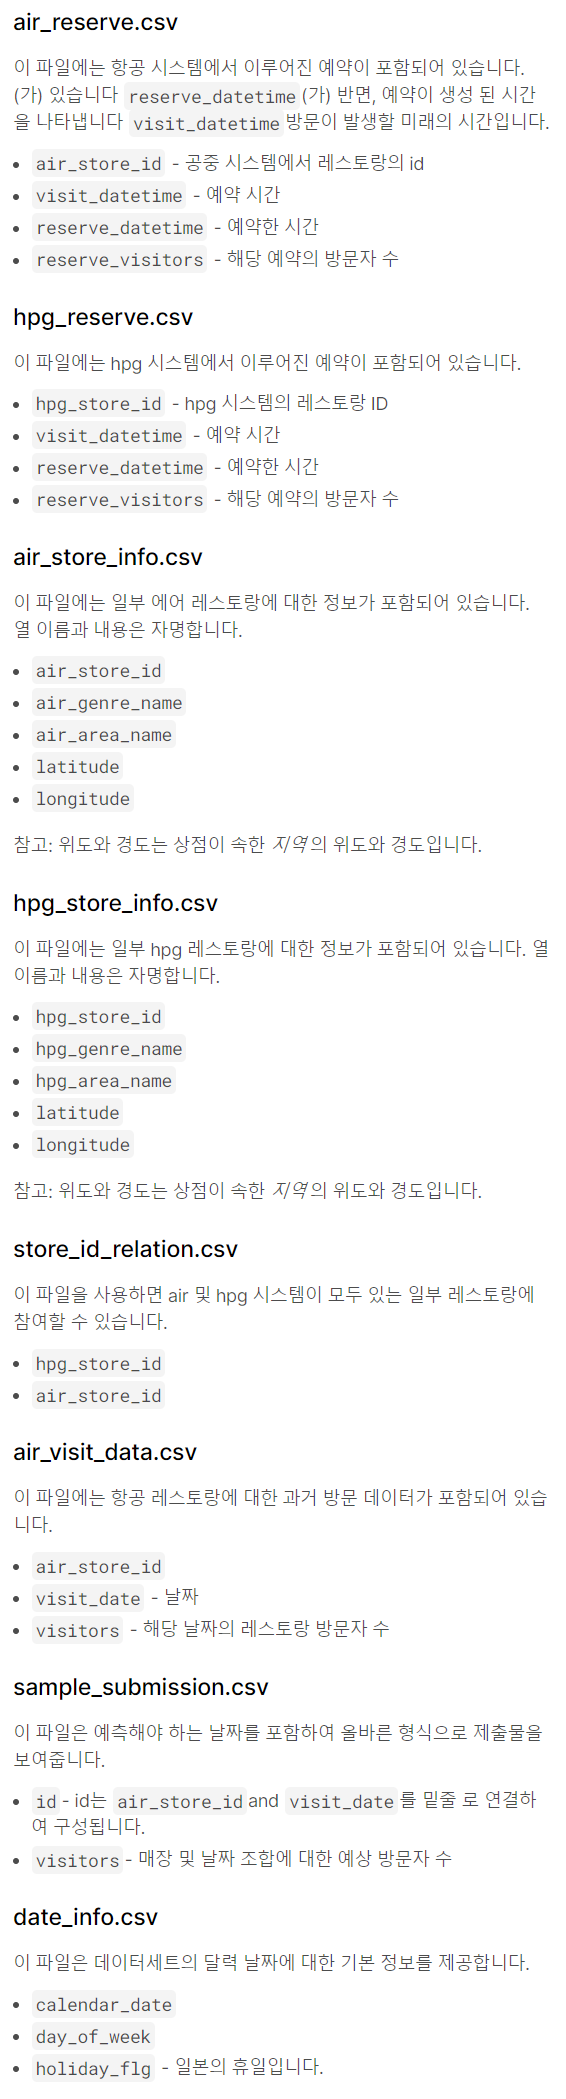

In [2]:
# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# 경고 메세지 무시
import warnings
warnings.filterwarnings(action='ignore')

# 경로 설정
import os
from os.path import join

# 데이터 불러오기 및 변형
import pandas as pd

# 다차원 배열 지원(벡터, 행렬 등 수치 연산)
import numpy as np

# 머신러닝 분석
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV # 그리드 탐색

# 머신러닝 모델
import lightgbm as lgb

# base n encoding
# import category_encoders as ce

# 그래프 작성 지원
%matplotlib inline

# 그래프 사이즈 조정(matplotlib -> 아래 이미지 참고)
# plt.rcParams["figure.figsize"] = (14,4)
# plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.color'] = 'r'
# plt.rcParams['axes.grid'] = True 

# !pip install category_encoders

In [3]:
# 코랩 실행 시
import os
data_path = '/content/drive/MyDrive/kaggle_1st_hackerton/data'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 쥬피터 실행시
# data_path = '\\Users\\woowo\\github\\Hackerton\\신웅철\\data'

# 데이터셋 로드
main_df = pd.read_csv(data_path +'/air_visit_data.csv')
asi_df = pd.read_csv(data_path + '/air_store_info.csv')
hsi_df = pd.read_csv(data_path + '/hpg_store_info.csv')
ar_df = pd.read_csv(data_path + '/air_reserve.csv')
hr_df = pd.read_csv(data_path + '/hpg_reserve.csv')
test_df = pd.read_csv(data_path + '/sample_submission.csv')
di_df = pd.read_csv(data_path + '/date_info.csv')
sir_df = pd.read_csv(data_path + '/store_id_relation.csv')

In [5]:
# 데이터셋 DataFrame
display(main_df.head())

display(test_df.head())

display(ar_df.head())

display(hsi_df.head())

display(asi_df.head())

display(hr_df.head())

display(sir_df.head())

display(di_df.head())

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [6]:
# 데이터셋 요약 정보

print('1. train')
main_df.info()
print(sep='\n')

print('2. test')
test_df.info()
print(sep='\n')

print('3. air_store_info')
asi_df.info()
print(sep='\n')

print('4. hpg_store_info')
hsi_df.info()
print(sep='\n')

print('5. air_reserve')
ar_df.info(null_counts=True)
print(sep='\n')

print('6. hpg_reserve')
hr_df.info()
print(sep='\n')

print('7. store_id_relation')
sir_df.info()
print(sep='\n')

print('8.date_info')
di_df.info()
print(sep='\n')

1. train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB

2. test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32019 non-null  object
 1   visitors  32019 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.4+ KB

3. air_store_info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    

## 2. Preprocessing

In [7]:
# air_reserve - air_store 데이터 전환
ar_df['visit_datetime'] = ar_df['visit_datetime'].apply(pd.to_datetime)
ar_df['visit_datetime'] = ar_df['visit_datetime'].dt.date
ar_df['reserve_datetime'] = ar_df['reserve_datetime'].apply(pd.to_datetime)
ar_df['reserve_datetime'] = ar_df['reserve_datetime'].dt.date
ar_df['reserve_datetime_diff_ar'] = ar_df.apply(lambda df: (df['visit_datetime'] - df['reserve_datetime']).days, axis=1)
ar_df = ar_df.groupby(['air_store_id', 'visit_datetime'], as_index=False)[[
        'reserve_datetime_diff_ar', 'reserve_visitors']].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })

ar_df.head()

,air_store_id,visit_date,reserve_datetime_diff_ar,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4


In [8]:
# hpg_reserve - air_store 데이터 전환
hr_df = pd.merge(hr_df, sir_df, how='inner', on=['hpg_store_id'])
hr_df['visit_datetime'] = hr_df['visit_datetime'].apply(pd.to_datetime)
hr_df['visit_datetime'] = hr_df['visit_datetime'].dt.date
hr_df['reserve_datetime'] = hr_df['reserve_datetime'].apply(pd.to_datetime)
hr_df['reserve_datetime'] = hr_df['reserve_datetime'].dt.date
hr_df['reserve_datetime_diff_hr'] = hr_df.apply(lambda df: (df['visit_datetime'] - df['reserve_datetime']).days, axis=1)
hr_df = hr_df.groupby(['air_store_id', 'visit_datetime'], as_index=False)[[
        'reserve_datetime_diff_hr', 'reserve_visitors']].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })

hr_df.head()

,air_store_id,visit_date,reserve_datetime_diff_hr,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5


In [9]:
# sample_submission - 학습 데이터 날짜별 구분
main_df['visit_date'] = main_df['visit_date'].apply(pd.to_datetime)
main_df['dayofweek'] = main_df['visit_date'].dt.dayofweek
main_df['year'] = main_df['visit_date'].dt.year
main_df['month'] = main_df['visit_date'].dt.month
main_df['day'] = main_df['visit_date'].dt.day
main_df['visit_date'] = main_df['visit_date'].dt.date

main_df.head()

,air_store_id,visit_date,visitors,dayofweek,year,month,day
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,13
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,14
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,15
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,16
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,18


In [10]:
# sample_submission - 테스트 데이터 날짜 분리
test_df['visit_date'] =  test_df['id'].map(
    lambda x: str(x).split('_')[2])
test_df['air_store_id'] = test_df['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))
test_df['visit_date'] = test_df['visit_date'].apply(pd.to_datetime)
test_df['dayofweek'] = test_df['visit_date'].dt.dayofweek
test_df['year'] = test_df['visit_date'].dt.year
test_df['month'] = test_df['visit_date'].dt.month
test_df['day'] = test_df['visit_date'].dt.day
test_df['visit_date'] = test_df['visit_date'].dt.date

test_df.head()

,id,visitors,visit_date,air_store_id,dayofweek,year,month,day
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,23
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,24
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,25
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,26
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,27


In [11]:
# air_store_id 활용
unique_stores = test_df['air_store_id'].unique()
store_info_df = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dayofweek': [i] * len(unique_stores)}) for i in range(7)],
                   axis=0, ignore_index=True).reset_index(drop=True)

min_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors'].agg('min').rename(columns={
    'visitors' : 'min_visitors'})
max_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors'].agg('max').rename(columns={
    'visitors' : 'max_visitors'})
mean_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors'].agg('mean').rename(columns={
    'visitors' : 'mean_visitors'})
median_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors'].agg('median').rename(columns={
    'visitors' : 'median_visitors'})
count_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors'].agg('count').rename(columns={
    'visitors' : 'count_visitors'})

store_info_df = pd.merge(store_info_df, asi_df, how='left', on=['air_store_id'])
store_info_df = pd.merge(store_info_df, min_df, how='left', on=['air_store_id', 'dayofweek'])
store_info_df = pd.merge(store_info_df, max_df, how='left', on=['air_store_id', 'dayofweek'])
store_info_df = pd.merge(store_info_df, mean_df, how='left', on=['air_store_id', 'dayofweek'])
store_info_df = pd.merge(store_info_df, count_df, how='left', on=['air_store_id', 'dayofweek'])

store_info_df.head()

,air_store_id,dayofweek,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors
0,air_00a91d42b08b08d9,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,1.0,47.0,22.457143,35.0
1,air_0164b9927d20bcc3,0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2.0,19.0,7.500000,20.0
2,air_0241aa3964b7f861,0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996,2.0,23.0,8.920635,63.0
3,air_0328696196e46f18,0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090,2.0,27.0,6.416667,12.0
4,air_034a3d5b40d5b1b1,0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229,1.0,66.0,11.864865,37.0


In [12]:
# air_visit_data - "air_genre_name"과 "air_area_name" 인코딩
# 1: 라벨 인코딩

lbl = LabelEncoder()
store_info_df['air_genre_name'] = lbl.fit_transform(store_info_df['air_genre_name'])
store_info_df['air_area_name'] = lbl.fit_transform(store_info_df['air_area_name'])
store_info_df.head()

,air_store_id,dayofweek,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors
0,air_00a91d42b08b08d9,0,6,44,35.694003,139.753595,1.0,47.0,22.457143,35.0
1,air_0164b9927d20bcc3,0,6,62,35.658068,139.751599,2.0,19.0,7.500000,20.0
2,air_0241aa3964b7f861,0,7,82,35.712607,139.779996,2.0,23.0,8.920635,63.0
3,air_0328696196e46f18,0,4,98,34.701279,135.528090,2.0,27.0,6.416667,12.0
4,air_034a3d5b40d5b1b1,0,2,102,34.692337,135.472229,1.0,66.0,11.864865,37.0


In [13]:
# air_visit_data - "air_genre_name"과 "air_area_name" 인코딩
# ordinal 변수가 아닌 nominal 변수이므로 이에 적합한 인코딩 방법을 찾아봤습니다.
# 2: base n encoding
# 하지만 성능이 떨어지는(score가 낮아지는) 결과에 이르러서, 사용하지 않는 것이 좋을 것 같습니다.
'''
encoder= ce.BaseNEncoder(cols=['air_genre_name'],return_df=True,base=4)
store_info_df= encoder.fit_transform(store_info_df)
encoder= ce.BaseNEncoder(cols=['air_area_name'],return_df=True,base=5)
store_info_df = encoder.fit_transform(store_info_df)
print("인코딩 후:\n")
display(store_info_df)
'''

'\nencoder= ce.BaseNEncoder(cols=[\'air_genre_name\'],return_df=True,base=4)\nstore_info_df= encoder.fit_transform(store_info_df)\nencoder= ce.BaseNEncoder(cols=[\'air_area_name\'],return_df=True,base=5)\nstore_info_df = encoder.fit_transform(store_info_df)\nprint("인코딩 후:\n")\ndisplay(store_info_df)\n'

In [14]:
main_df = pd.merge(main_df, store_info_df, how='left', on=['air_store_id', 'dayofweek'])
test_df = pd.merge(test_df, store_info_df, how='left', on=['air_store_id', 'dayofweek'])

In [15]:
# air_visit_data - 수치형 데이터 변환(genre, area)
'''
main_df = pd.merge(main_df, asi_df, how='left', on=['air_store_id'])
lbl = LabelEncoder()
main_df['air_genre_name'] = lbl.fit_transform(main_df['air_genre_name'])
main_df['air_area_name'] = lbl.fit_transform(main_df['air_area_name'])
main_df.head()
'''

"\nmain_df = pd.merge(main_df, asi_df, how='left', on=['air_store_id'])\nlbl = LabelEncoder()\nmain_df['air_genre_name'] = lbl.fit_transform(main_df['air_genre_name'])\nmain_df['air_area_name'] = lbl.fit_transform(main_df['air_area_name'])\nmain_df.head()\n"

In [16]:
# sample_submission - 수치형 데이터 변환(genre, area)
'''
test_df = pd.merge(test_df, asi_df, how='left', on=['air_store_id'])
lbl = LabelEncoder()
test_df['air_genre_name'] = lbl.fit_transform(test_df['air_genre_name'])
test_df['air_area_name'] = lbl.fit_transform(test_df['air_area_name'])
test_df.head()
'''

"\ntest_df = pd.merge(test_df, asi_df, how='left', on=['air_store_id'])\nlbl = LabelEncoder()\ntest_df['air_genre_name'] = lbl.fit_transform(test_df['air_genre_name'])\ntest_df['air_area_name'] = lbl.fit_transform(test_df['air_area_name'])\ntest_df.head()\n"

In [17]:
di_df.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [18]:
# air_visit_data, sample_submission - 수치형 데이터 변환(요일)
def mapping_func(day):
    if day == 'Monday': return 0
    if day == 'Tuesday': return 1
    if day == 'Wednesday': return 2
    if day == 'Thursday': return 3
    if day == 'Friday': return 4
    if day == 'Saturday': return 5
    else: return 6
    
di_df.rename(columns={
    'calendar_date' : 'visit_date',
    'day_of_week' : 'dayofweek'}, inplace=True)
di_df['visit_date'] = di_df['visit_date'].apply(pd.to_datetime)
di_df['dayofweek'] = di_df['dayofweek'].apply(mapping_func)
di_df['visit_date'] = di_df['visit_date'].dt.date

In [19]:
di_main_df = di_df[:478] # 2016.1.1 ~ 2017.4.22 
di_test_df = di_df[478:] # 2017.4.23 ~ 

di_df.head()

,visit_date,dayofweek,holiday_flg
0,2016-01-01,4,1
1,2016-01-02,5,1
2,2016-01-03,6,1
3,2016-01-04,0,0
4,2016-01-05,1,0


In [20]:
di_main_df

,visit_date,dayofweek,holiday_flg
0,2016-01-01,4,1
1,2016-01-02,5,1
2,2016-01-03,6,1
3,2016-01-04,0,0
4,2016-01-05,1,0
...,...,...,...
473,2017-04-18,1,0
474,2017-04-19,2,0
475,2017-04-20,3,0
476,2017-04-21,4,0


In [21]:
main_df

,air_store_id,visit_date,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,13,4.0,62.0,35.658068,139.751599,7.0,57.0,23.843750,64.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,14,4.0,62.0,35.658068,139.751599,2.0,54.0,20.292308,65.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,15,4.0,62.0,35.658068,139.751599,4.0,61.0,34.738462,65.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,16,4.0,62.0,35.658068,139.751599,6.0,53.0,27.651515,66.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,18,4.0,62.0,35.658068,139.751599,2.0,34.0,13.754386,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,18,11.0,72.0,35.653217,139.711036,2.0,11.0,5.615385,39.0
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,19,11.0,72.0,35.653217,139.711036,2.0,25.0,6.575000,40.0
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,20,11.0,72.0,35.653217,139.711036,2.0,8.0,5.394737,38.0
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,21,11.0,72.0,35.653217,139.711036,2.0,9.0,5.738095,42.0


In [22]:
# main dataset 인 air_visit_data - 컬럼 병합
main_df = pd.merge(main_df, ar_df, how='left', on=['air_store_id', 'visit_date'], suffixes=('_ar', '_hr'))
main_df = pd.merge(main_df, hr_df, how='left', on=['air_store_id', 'visit_date'], suffixes=('_ar', '_hr'))
main_df = pd.merge(main_df, di_main_df, how='left', on=['visit_date', 'dayofweek'], suffixes=('_ar', '_hr'))

main_df.head()

,air_store_id,visit_date,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,13,4.0,62.0,35.658068,139.751599,7.0,57.0,23.843750,64.0,NaN,NaN,NaN,NaN,0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,14,4.0,62.0,35.658068,139.751599,2.0,54.0,20.292308,65.0,NaN,NaN,NaN,NaN,0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,15,4.0,62.0,35.658068,139.751599,4.0,61.0,34.738462,65.0,NaN,NaN,NaN,NaN,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,16,4.0,62.0,35.658068,139.751599,6.0,53.0,27.651515,66.0,NaN,NaN,NaN,NaN,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,18,4.0,62.0,35.658068,139.751599,2.0,34.0,13.754386,57.0,NaN,NaN,NaN,NaN,0


In [23]:
# sample_submission - 컬럼 병합
test_df = pd.merge(test_df, ar_df, how='left', on=['air_store_id', 'visit_date'], suffixes=('_ar', '_hr'))
test_df = pd.merge(test_df, hr_df, how='left', on=['air_store_id', 'visit_date'], suffixes=('_ar', '_hr'))
test_df = pd.merge(test_df, di_test_df, how='left', on=['visit_date', 'dayofweek'], suffixes=('_ar', '_hr'))

test_df.head()

,id,visitors,visit_date,air_store_id,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,23,6,44,35.694003,139.753595,2.0,2.0,2.000000,1.0,NaN,NaN,NaN,NaN,0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,24,6,44,35.694003,139.753595,1.0,47.0,22.457143,35.0,NaN,NaN,NaN,NaN,0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,25,6,44,35.694003,139.753595,1.0,43.0,24.350000,40.0,NaN,NaN,NaN,NaN,0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,26,6,44,35.694003,139.753595,15.0,52.0,28.125000,40.0,NaN,NaN,NaN,NaN,0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,27,6,44,35.694003,139.753595,15.0,47.0,29.868421,38.0,NaN,NaN,NaN,NaN,0


# 3. EDA
1. 결측값 CHECK
2. 이상값 확인
3. 상관관계
4. 시계열 시각화
5. 범주형 변수
6. 공간 데이터 시각화 (latitude, longitude) 

### 변수 설명
1. air_store_id(점포id) : 점포별 특성 추출 시 유용 / 517일 동안 한 점포 통계량
2. visitors(방문자) : 타겟분류
3. dayofweek(요일) : 0~6까지 라벨 인코딩
4. year(년) 
5. month(월)
6. day(일)
7. air_genre_name(점포유형) : 라벨 인코딩
8. air_area_name(점포지역) : 라벨 인코딩
9. min_visitors(최소 방문자수)
10. median_visitors(중간 방문자수)
11. max_visitors(최고 방문자수)
12. mean_visitors(평균 방문자수)

### 고객 예약 패턴에 따른 방문 일자 상관관계 ⬆
#### 다수의 결측치로 인해 방문자와의 상관관계를 정확히 파악하지 못함
14. reserve_datetime_diff_ar(예약 및 방문일자 차이)
15. reserve_datetime_diff_hr(예약 및 방문일자 차이)

### 예약 방문자에 따른 실제 방문자 예측성 ⬆
#### vistors와 상관관계 시각화 후 모델링을 통해 reserved_visitor 결측값을 예측하는 시도
16. reserve_visitors_ar(예약 방문자)
17. reserve_visitors_hr(예약 방문자)

### Feature Design & Reliability - Geo Feature, Date Feature
#### 위도 경도를 통해 파생 변수를 생성(역세권 및 관광지 거리)
- 국내 관광지 표준 데이터 : https://www.data.go.kr/data/15021141/standard.do
18. latitude(위도)
19. longitude(경도)

#### 데이터 이상치 최소화를 위한 검증
13. holiday_flg(휴일수)

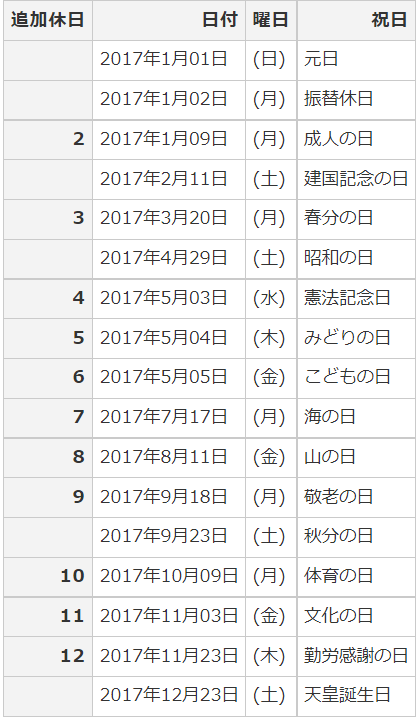

### 1. 결측치 확인

In [24]:
# Missing Ratio - main, test
main_df_na = (main_df.isnull().sum() / len(main_df)) * 100
main_df_na = main_df_na.drop(main_df_na[main_df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio" : main_df_na})
missing_data.head(20)

test_df_na = (test_df.isnull().sum() / len(main_df)) * 100
test_df_na = test_df_na.drop(test_df_na[test_df_na == 0].index).sort_values(ascending=False)
missing_test_data = pd.DataFrame({"Missing Ratio" : test_df_na})
missing_test_data.head(20)

,Missing Ratio
reserve_visitors_hr,12.569613
reserve_datetime_diff_hr,12.569613
reserve_visitors_ar,12.251892
reserve_datetime_diff_ar,12.251892
count_visitors,0.135259
mean_visitors,0.135259
max_visitors,0.135259
min_visitors,0.135259


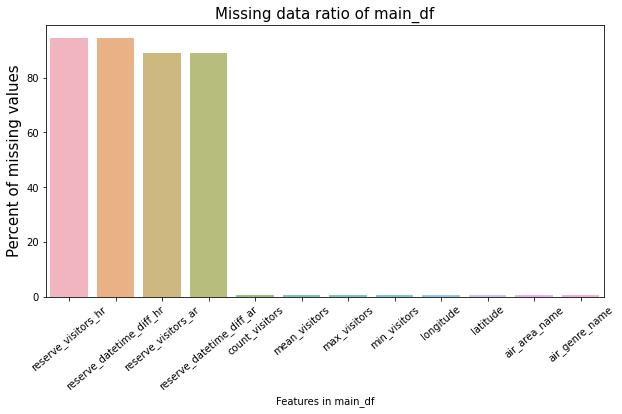

In [25]:
# missing data graph
f, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=main_df_na.index, y=main_df_na, alpha=0.7)
plt.xticks(rotation=40)
plt.xlabel('Features in main_df', fontsize=10)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Missing data ratio of main_df', fontsize=15)
plt.show()

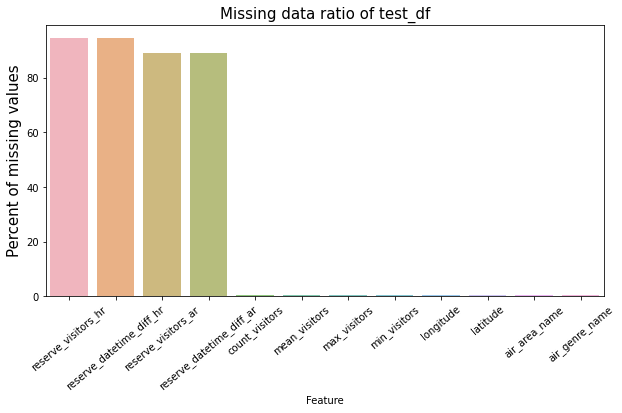

In [26]:
f, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=main_df_na.index, y=main_df_na, alpha=0.7)
plt.xticks(rotation=40)
plt.xlabel('Feature', fontsize=10)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Missing data ratio of test_df', fontsize=15)
plt.show()

In [27]:
# missing data remove - nan값 '-1' 적용
main_df = main_df.fillna(-1)
test_df = test_df.fillna(-1)

### 결측치 제거를 위한 시도

In [28]:
'''
# 결측치 입력(reserve_datetime_diff)
main_df = main_df.fillna({'reserve_datetime_diff_ar' : ar_df['reserve_datetime_diff_ar'].mean(axis=0), 'reserve_datetime_diff_hr' : hr_df['reserve_datetime_diff_hr'].mean(axis=0), 'air_genre_name_0' : 0, 'air_area_name_0' : 0, 'reserve_visitors_hr' : hr_df['reserve_visitors'].mean(axis=0), 'reserve_visitors_ar' : ar_df['reserve_visitors'].mean(axis=0)})
test_df = test_df.fillna({'reserve_datetime_diff_ar' : ar_df['reserve_datetime_diff_ar'].mean(axis=0), 'reserve_datetime_diff_hr' : hr_df['reserve_datetime_diff_hr'].mean(axis=0), 'air_genre_name_0' : 0, 'air_area_name_0' : 0, 'reserve_visitors_hr' : hr_df['reserve_visitors'].mean(axis=0), 'reserve_visitors_ar' : ar_df['reserve_visitors'].mean(axis=0)})

# 결측치 입력(visitors data)
main_df = main_df.fillna(-1)
test_df = test_df.fillna(-1)
'''

"\n# 결측치 입력(reserve_datetime_diff)\nmain_df = main_df.fillna({'reserve_datetime_diff_ar' : ar_df['reserve_datetime_diff_ar'].mean(axis=0), 'reserve_datetime_diff_hr' : hr_df['reserve_datetime_diff_hr'].mean(axis=0), 'air_genre_name_0' : 0, 'air_area_name_0' : 0, 'reserve_visitors_hr' : hr_df['reserve_visitors'].mean(axis=0), 'reserve_visitors_ar' : ar_df['reserve_visitors'].mean(axis=0)})\ntest_df = test_df.fillna({'reserve_datetime_diff_ar' : ar_df['reserve_datetime_diff_ar'].mean(axis=0), 'reserve_datetime_diff_hr' : hr_df['reserve_datetime_diff_hr'].mean(axis=0), 'air_genre_name_0' : 0, 'air_area_name_0' : 0, 'reserve_visitors_hr' : hr_df['reserve_visitors'].mean(axis=0), 'reserve_visitors_ar' : ar_df['reserve_visitors'].mean(axis=0)})\n\n# 결측치 입력(visitors data)\nmain_df = main_df.fillna(-1)\ntest_df = test_df.fillna(-1)\n"

In [29]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   air_store_id              252108 non-null  object 
 1   visit_date                252108 non-null  object 
 2   visitors                  252108 non-null  int64  
 3   dayofweek                 252108 non-null  int64  
 4   year                      252108 non-null  int64  
 5   month                     252108 non-null  int64  
 6   day                       252108 non-null  int64  
 7   air_genre_name            252108 non-null  float64
 8   air_area_name             252108 non-null  float64
 9   latitude                  252108 non-null  float64
 10  longitude                 252108 non-null  float64
 11  min_visitors              252108 non-null  float64
 12  max_visitors              252108 non-null  float64
 13  mean_visitors             252108 non-null  f

In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        32019 non-null  object 
 1   visitors                  32019 non-null  int64  
 2   visit_date                32019 non-null  object 
 3   air_store_id              32019 non-null  object 
 4   dayofweek                 32019 non-null  int64  
 5   year                      32019 non-null  int64  
 6   month                     32019 non-null  int64  
 7   day                       32019 non-null  int64  
 8   air_genre_name            32019 non-null  int64  
 9   air_area_name             32019 non-null  int64  
 10  latitude                  32019 non-null  float64
 11  longitude                 32019 non-null  float64
 12  min_visitors              32019 non-null  float64
 13  max_visitors              32019 non-null  float64
 14  mean_v

In [31]:
main_df.head()

,air_store_id,visit_date,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,13,4.0,62.0,35.658068,139.751599,7.0,57.0,23.843750,64.0,-1.0,-1.0,-1.0,-1.0,0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,14,4.0,62.0,35.658068,139.751599,2.0,54.0,20.292308,65.0,-1.0,-1.0,-1.0,-1.0,0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,15,4.0,62.0,35.658068,139.751599,4.0,61.0,34.738462,65.0,-1.0,-1.0,-1.0,-1.0,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,16,4.0,62.0,35.658068,139.751599,6.0,53.0,27.651515,66.0,-1.0,-1.0,-1.0,-1.0,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,18,4.0,62.0,35.658068,139.751599,2.0,34.0,13.754386,57.0,-1.0,-1.0,-1.0,-1.0,0


### 2. 이상값 확인

In [32]:
feature_list = list(main_df.columns)
print(len(feature_list))

20


In [33]:
def show_scatter(feature_list, i, j):
    plt.figure(figsize=(25,5))
    idx = 1
    for feature in feature_list:
        if idx <= (i * j):
            plt.subplot(i, j, idx)
            plt.scatter(x=main_df[feature], y=main_df['visitors'])
            plt.xlabel(feature, fontsize=13)
            plt.ylabel('visitors', fontsize=13)
            plt.xticks([])
            idx += 1
        else:
            break
    plt.show()

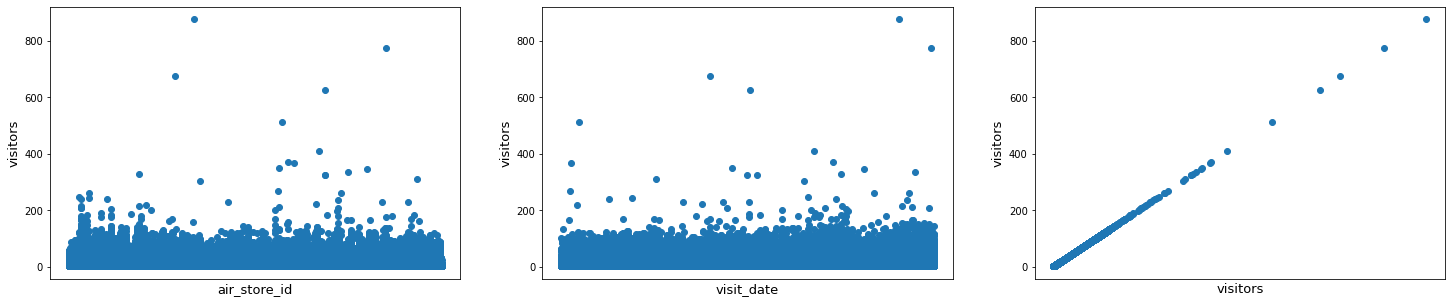

In [34]:
show_scatter(feature_list[:3], 1, 3)

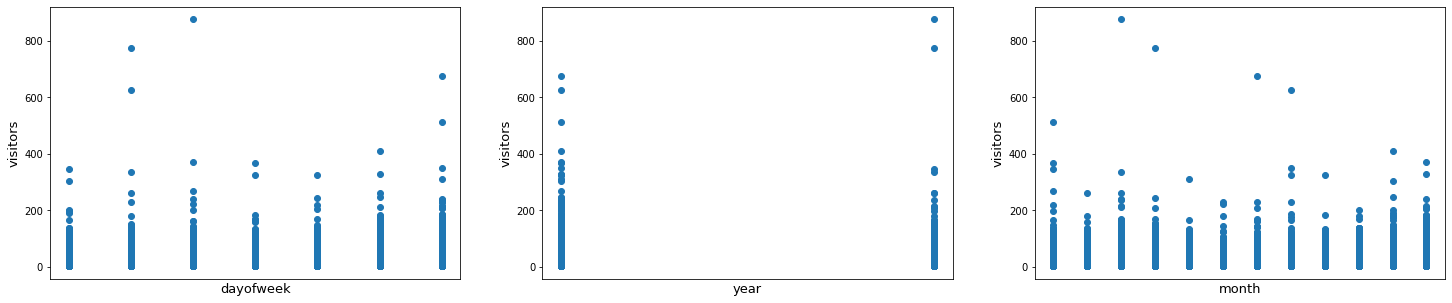

In [35]:
show_scatter(feature_list[3:6], 1, 3)

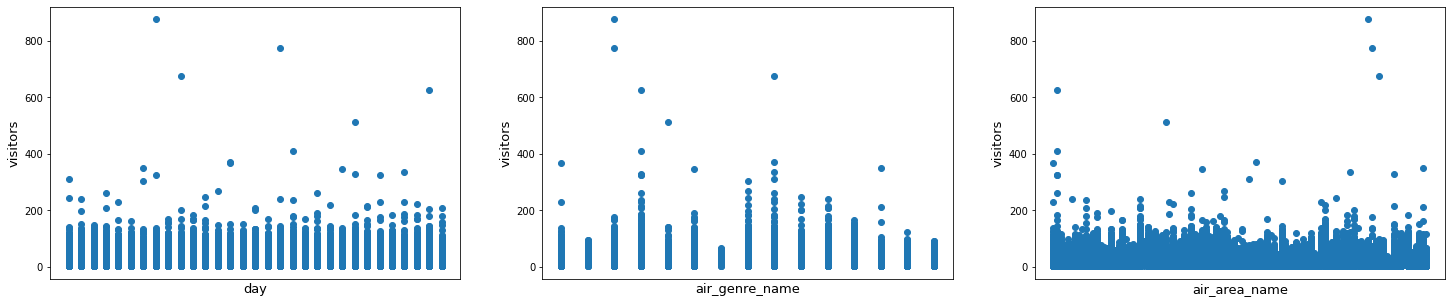

In [36]:
show_scatter(feature_list[6:9], 1, 3)

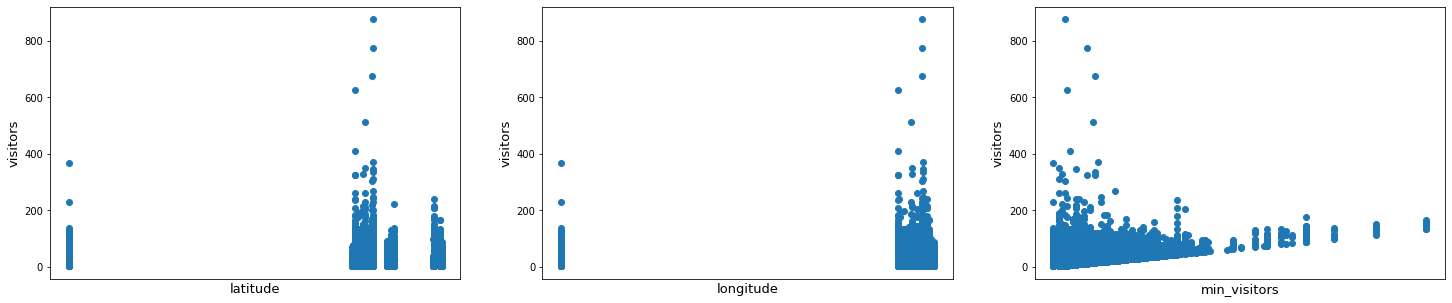

In [37]:
show_scatter(feature_list[9:12], 1, 3)

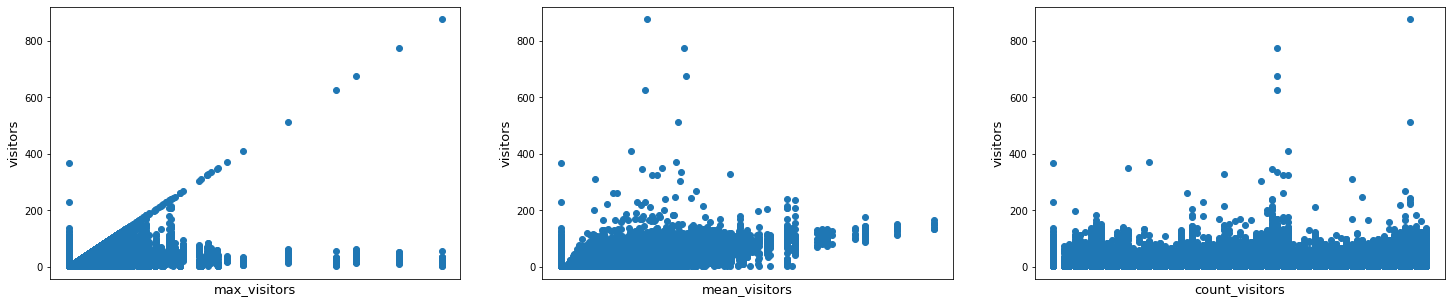

In [38]:
show_scatter(feature_list[12:15], 1, 3)

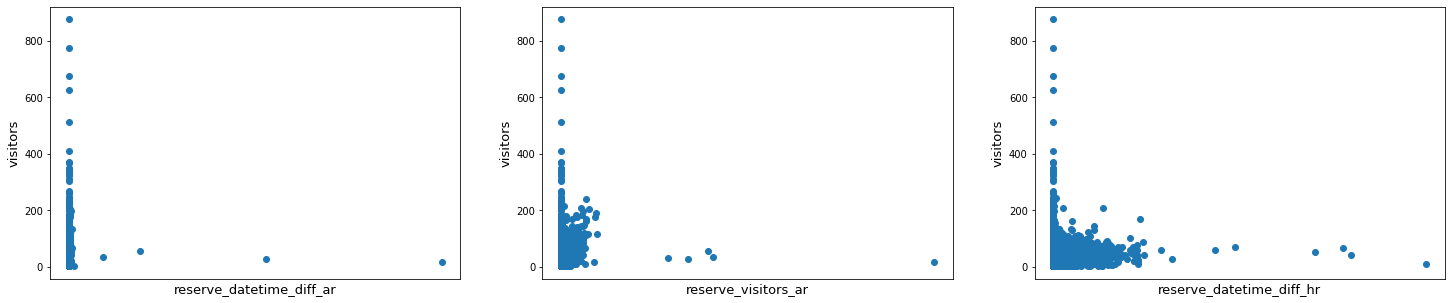

In [39]:
show_scatter(feature_list[15:18], 1, 3)

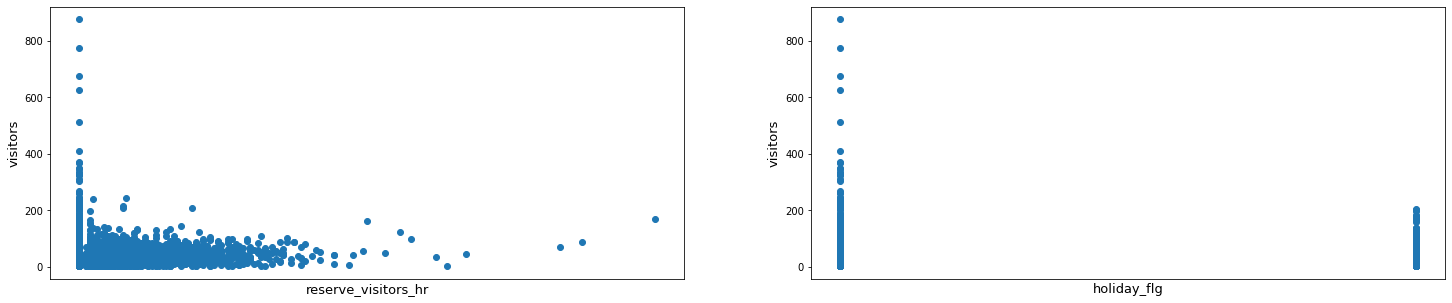

In [40]:
show_scatter(feature_list[18:], 1, 2)

- 산점도를 보면 범주형 변수는 "dayofweek, year, month, day, air_genre_name, air_area_name, holiday_flg"가 있다. 이들의 적절한 인코딩이 필요한 바이다.

20.973761245180636 16.756974080364415


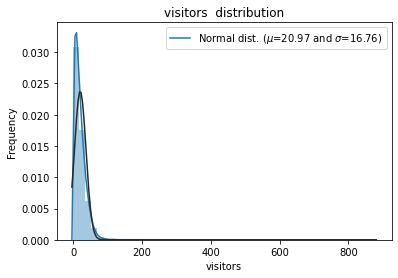

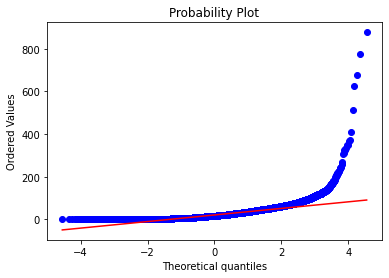

In [41]:
# data 정규분포성 확인
from scipy import stats
from scipy.stats import norm, skew

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(main_df['visitors'], fit=norm)
(mu, sigma) = norm.fit(main_df['visitors'])

print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('visitors  distribution')
fig = plt.figure()
res = stats.probplot(main_df['visitors'], plot=plt)
plt.show()

2.802788288457785 0.8077240821434067


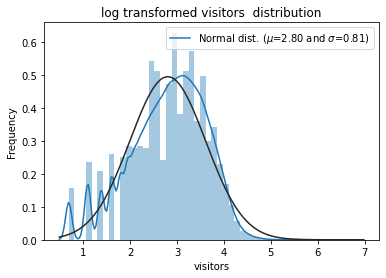

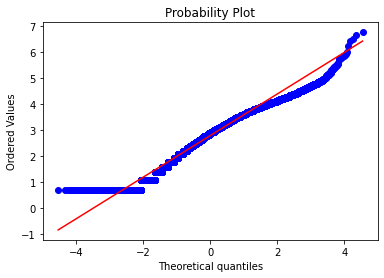

In [42]:
# log 변환을 통한 정규분포화
from scipy import stats
from scipy.stats import norm, skew

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(np.log1p(main_df['visitors']), fit=norm)
(mu, sigma) = norm.fit(np.log1p(main_df['visitors']))
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('log transformed visitors  distribution')
fig = plt.figure()
res = stats.probplot(np.log1p(main_df['visitors']), plot=plt)
plt.show()

### 3. 상관관계 분석

In [43]:
corr_df = main_df.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df = corr_df.fillna(0)
corr_df

,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
visitors,1.00,0.18,-0.00,-0.00,0.02,0.06,-0.02,-0.01,-0.01,0.55,0.45,0.74,0.08,0.01,0.21,0.09,0.12,0.04
dayofweek,0.18,1.00,0.00,-0.00,-0.02,-0.02,-0.00,-0.01,-0.02,0.19,0.12,0.23,0.05,0.01,0.04,0.05,0.05,-0.05
year,-0.00,0.00,1.00,-0.68,-0.04,0.00,0.00,0.02,0.02,0.03,-0.00,0.02,-0.14,0.01,0.09,0.00,0.01,-0.06
month,-0.00,-0.00,-0.68,1.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.01,-0.01,-0.12,-0.00,-0.04,0.03,0.02,0.06
day,0.02,-0.02,-0.04,-0.00,1.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,-0.01,0.00,-0.00,0.02,0.03,0.02,0.01
air_genre_name,0.06,-0.02,0.00,-0.00,0.00,1.00,-0.04,0.19,0.16,0.01,0.03,0.10,0.06,0.01,0.12,0.06,0.07,-0.01
air_area_name,-0.02,-0.00,0.00,-0.00,-0.00,-0.04,1.00,0.12,0.30,0.02,-0.03,-0.01,0.03,-0.01,-0.09,-0.06,-0.08,-0.01
latitude,-0.01,-0.01,0.02,0.00,0.00,0.19,0.12,1.00,0.90,0.04,0.11,0.11,0.20,0.01,0.06,0.03,0.03,0.00
longitude,-0.01,-0.02,0.02,-0.00,-0.00,0.16,0.30,0.90,1.00,0.08,0.10,0.13,0.26,0.00,0.01,0.00,0.00,-0.00
min_visitors,0.55,0.19,0.03,0.00,-0.01,0.01,0.02,0.04,0.08,1.00,0.34,0.74,0.02,0.01,0.09,0.03,0.03,-0.01


In [44]:
s = corr_df.unstack()
df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

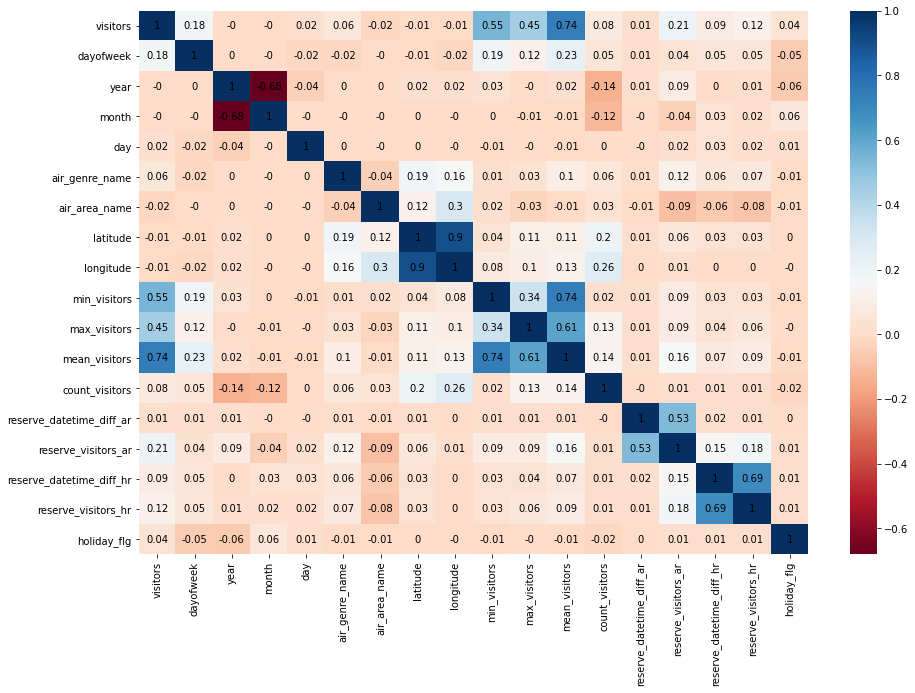

In [45]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(corr_df, annot=True, annot_kws=dict(color='black'), cmap='RdBu')
plt.show()

### 4. 시계열 데이터 시각화

In [46]:
main_df_copy = main_df.copy()

In [47]:
main_df['visit_date']

0         2016-01-13
1         2016-01-14
2         2016-01-15
3         2016-01-16
4         2016-01-18
             ...    
252103    2017-04-18
252104    2017-04-19
252105    2017-04-20
252106    2017-04-21
252107    2017-04-22
Name: visit_date, Length: 252108, dtype: object

In [48]:
main_df['visit_date'] = main_df['visit_date'].apply(pd.to_datetime)

In [49]:
main_df.set_index('visit_date', inplace=True)

In [50]:
main_df

,air_store_id,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
visit_date,,,,,,,,,,,,,,,,,,,
2016-01-13,air_ba937bf13d40fb24,25,2,2016,1,13,4.0,62.0,35.658068,139.751599,7.0,57.0,23.843750,64.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-14,air_ba937bf13d40fb24,32,3,2016,1,14,4.0,62.0,35.658068,139.751599,2.0,54.0,20.292308,65.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-15,air_ba937bf13d40fb24,29,4,2016,1,15,4.0,62.0,35.658068,139.751599,4.0,61.0,34.738462,65.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-16,air_ba937bf13d40fb24,22,5,2016,1,16,4.0,62.0,35.658068,139.751599,6.0,53.0,27.651515,66.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-18,air_ba937bf13d40fb24,6,0,2016,1,18,4.0,62.0,35.658068,139.751599,2.0,34.0,13.754386,57.0,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-18,air_24e8414b9b07decb,6,1,2017,4,18,11.0,72.0,35.653217,139.711036,2.0,11.0,5.615385,39.0,-1.0,-1.0,-1.0,-1.0,0
2017-04-19,air_24e8414b9b07decb,6,2,2017,4,19,11.0,72.0,35.653217,139.711036,2.0,25.0,6.575000,40.0,-1.0,-1.0,-1.0,-1.0,0
2017-04-20,air_24e8414b9b07decb,7,3,2017,4,20,11.0,72.0,35.653217,139.711036,2.0,8.0,5.394737,38.0,-1.0,-1.0,-1.0,-1.0,0


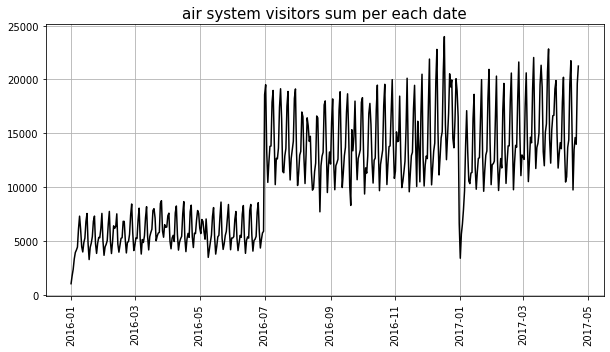

In [51]:
# main data 에서 방문날짜별 방문객 총합을 그래프로 그려봅니다.
# 2016년 7월을 threshold로 이전에는 일정 규모의 주간 패턴을 그리다가, 이후에는 등록 식당 수가 늘어난 듯한 증가가 보입니다.
# 일별 10000명에서 20000명 사이에서 데이터가 분포하는 흐름이 보입니다.
main_df_copy['visit_date'] = pd.to_datetime(main_df_copy['visit_date'])
copy_main = main_df_copy.copy()

copy_main_1 = copy_main.groupby(
        ['visit_date'], as_index=False)[[
            'visitors'
        ]].sum()

plt.figure(figsize=(10,5))
plt.title("air system visitors sum per each date", fontsize=15)
plt.plot(copy_main_1["visit_date"].dt.date, copy_main_1["visitors"], color='black')
plt.grid()
plt.xticks(rotation=90)
plt.show()

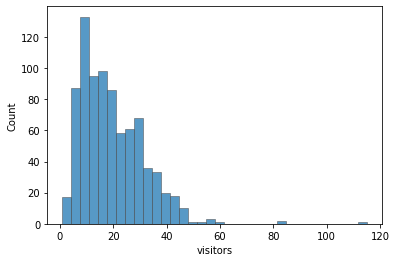

In [52]:
# 가게 별 방문자 수의 중앙값을 histogram으로 그려봅니다.
# 왼쪽으로 치우친 형태를 가지고 있습니다. 방문자 수가 이상치를 가지고 있다는 점을 알 수 있습니다.
copy_main_2 = copy_main.groupby(
    ["air_store_id"], as_index=False)[[
          "visitors"
    ]].median()

sns.histplot(
    copy_main_2,
    x="visitors",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
)

In [53]:
def rev_mapping_func(num):
    if num == 0: return 'Mon'
    if num == 1: return 'Tue'
    if num == 2: return 'Wed'
    if num == 3: return 'Thu'
    if num == 4: return 'Fri'
    if num == 5: return 'Sat'
    else: return 'Sun'

<BarContainer object of 7 artists>

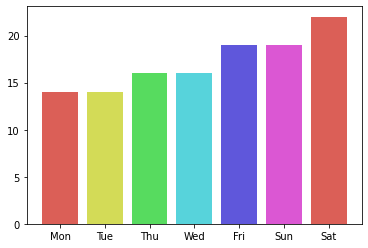

In [54]:
# 요일별 방문객수의 중앙값을 보면, 금/일은 비슷한 수준이며 토요일이 가장 높다.
# 요일별로 가게 방문자 수의 통계값을 feature에 포함시키는 것이 좋을 것 같다.
copy_main_3=copy_main.copy()
copy_main_3["dayofweek"] = copy_main_3["dayofweek"].apply(rev_mapping_func)
copy_main_3 = copy_main_3.groupby(["dayofweek"], as_index=False)[[
                                  "visitors"]].median()
copy_main_3 = copy_main_3.sort_values(by="visitors")
colors = sns.color_palette('hls')
plt.bar(copy_main_3["dayofweek"],copy_main_3["visitors"], color=colors)

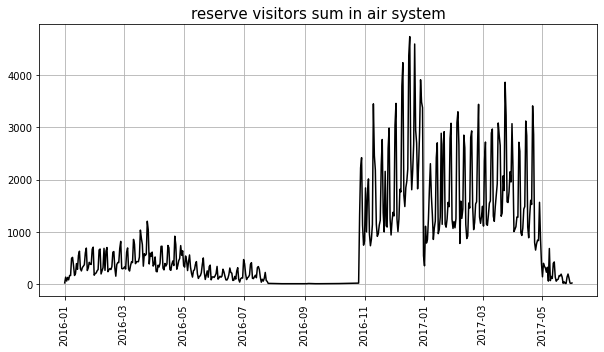

In [55]:
# air reserve 데이터에서 방문날짜 별 예약 방문자수의 총합을 그래프로 시각화해봅니다.
# 예약이 없던 구간도 있고, 2016년 11월 이후에는 급격히 상승한 것을 알 수 있습니다.
# training dataset 끝구간에는 예약방문자 수가 낮게 나타납니다.

ar_df["visit_date"]=pd.to_datetime(ar_df["visit_date"])
copy_ar = ar_df.copy()
copy_ar_1 = copy_ar.groupby(
        ['visit_date'], as_index=False)[[
            'reserve_visitors'
        ]].sum()

plt.figure(figsize=(10,5))
plt.title("reserve visitors sum in air system", fontsize=15)
plt.plot(copy_ar_1["visit_date"].dt.date, copy_ar_1["reserve_visitors"], color='black')
plt.grid()
plt.xticks(rotation=90)
plt.show()

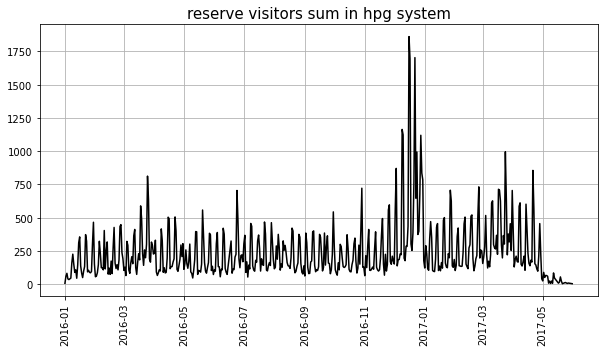

In [56]:
hr_df["visit_date"]=pd.to_datetime(hr_df["visit_date"])
copy_hr = hr_df.copy()
copy_hr_1 = copy_hr.groupby(
        ['visit_date'], as_index=False)[[
            'reserve_visitors'
        ]].sum()

plt.figure(figsize=(10,5))
plt.title("reserve visitors sum in hpg system", fontsize=15)
plt.plot(copy_hr_1["visit_date"].dt.date, copy_hr_1["reserve_visitors"], color='black')
plt.grid()
plt.xticks(rotation=90)
plt.show()

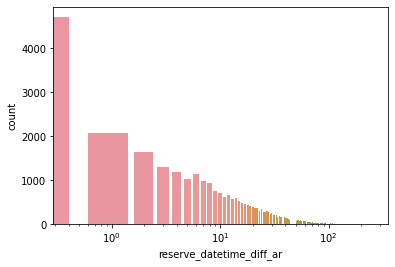

In [57]:
# air reserve 에서 예약시간과 방문시간의 차이가 이상한 값들이 있고, 주로 10 이하 값들이 많습니다.
# 특히 당일 예약이 많은 것 같습니다.
ax = sns.countplot(
    data=ar_df,
    x="reserve_datetime_diff_ar"
)
ax.set_xticklabels([])
ax.set_xscale('log')
plt.show()

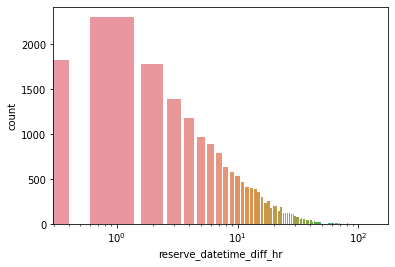

In [58]:
# hpg reserve 에서 예약시간과 방문시간의 차이가 이상한 값들이 많은 것 같습니다.
# 당일 예약 혹은 하루, 이틀 전 예약이 많이 나타납니다.

ax = sns.countplot(
    data=hr_df,
    x="reserve_datetime_diff_hr"
)
ax.set_xticklabels([])
ax.set_xscale('log')
plt.show()

## resample()
시계열 데이터를 처리할 때 자주 하는 것 중 하나가 시간 인덱스를 기준으로 resampling 하는 것입니다. 그러기 위해 **resample** 메서드를 사용합니다.

#### timeseries [offset alias](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) (중요)

<table border="1" class="docutils">
<colgroup>
<col width="13%" />
<col width="87%" />
</colgroup>
<thead valign="bottom">
<tr class="row-odd"><th class="head">Alias</th>
<th class="head">Description</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even"><td>B</td>
<td>business day frequency</td>
</tr>
<tr class="row-odd"><td>C</td>
<td>custom business day frequency (experimental)</td>
</tr>
<tr class="row-even"><td>D</td>
<td>calendar day frequency</td>
</tr>
<tr class="row-odd"><td>W</td>
<td>weekly frequency</td>
</tr>
<tr class="row-even"><td>M</td>
<td>month end frequency</td>
</tr>
<tr class="row-odd"><td>SM</td>
<td>semi-month end frequency (15th and end of month)</td>
</tr>
<tr class="row-even"><td>BM</td>
<td>business month end frequency</td>
</tr>
<tr class="row-odd"><td>CBM</td>
<td>custom business month end frequency</td>
</tr>
<tr class="row-even"><td>MS</td>
<td>month start frequency</td>
</tr>
<tr class="row-odd"><td>SMS</td>
<td>semi-month start frequency (1st and 15th)</td>
</tr>
<tr class="row-even"><td>BMS</td>
<td>business month start frequency</td>
</tr>
<tr class="row-odd"><td>CBMS</td>
<td>custom business month start frequency</td>
</tr>
<tr class="row-even"><td>Q</td>
<td>quarter end frequency</td>
</tr>
<tr class="row-odd"><td>BQ</td>
<td>business quarter endfrequency</td>
</tr>
<tr class="row-even"><td>QS</td>
<td>quarter start frequency</td>
</tr>
<tr class="row-odd"><td>BQS</td>
<td>business quarter start frequency</td>
</tr>
<tr class="row-even"><td>A</td>
<td>year end frequency</td>
</tr>
<tr class="row-odd"><td>BA</td>
<td>business year end frequency</td>
</tr>
<tr class="row-even"><td>AS</td>
<td>year start frequency</td>
</tr>
<tr class="row-odd"><td>BAS</td>
<td>business year start frequency</td>
</tr>
<tr class="row-even"><td>BH</td>
<td>business hour frequency</td>
</tr>
<tr class="row-odd"><td>H</td>
<td>hourly frequency</td>
</tr>
<tr class="row-even"><td>T, min</td>
<td>minutely frequency</td>
</tr>
<tr class="row-odd"><td>S</td>
<td>secondly frequency</td>
</tr>
<tr class="row-even"><td>L, ms</td>
<td>milliseconds</td>
</tr>
<tr class="row-odd"><td>U, us</td>
<td>microseconds</td>
</tr>
<tr class="row-even"><td>N</td>
<td>nanoseconds</td>
</tr>
</tbody>
</table>

**resample** 호출 시 rule 파라메터를 입력해야 하는데, 입력한 rule 단위로 resampling 하게 됩니다. resampling 되어 리턴된 객체의 row 를 재조합하기 위해 aggregation 함수 (mean, sum, count, etc) 따위를 실행해서 결과를 도출합니다.

In [59]:
# 월간 평균
main_df.resample(rule='W').mean()

,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
visit_date,,,,,,,,,,,,,,,,,,
2016-01-03,26.901042,5.171875,2016.0,1.000000,2.171875,4.901042,39.307292,34.762534,133.268291,6.494792,58.520833,25.288011,63.666667,-0.833333,0.114583,-0.906250,-0.765625,1.000000
2016-01-10,20.951957,3.202254,2016.0,1.000000,7.202254,5.285884,48.986358,35.097208,135.806917,4.848161,51.383155,21.041614,61.467972,-0.555160,0.203440,-0.857058,-0.821471,0.000000
2016-01-17,21.181563,3.072513,2016.0,1.000000,14.072513,5.197864,49.809444,35.126499,135.918054,4.770658,51.109050,20.784342,61.336706,-0.010680,0.492411,-0.792018,-0.768409,0.113547
2016-01-24,20.265565,2.999449,2016.0,1.000000,20.999449,5.269421,49.968595,35.132392,135.958175,4.722865,51.099174,20.708804,62.015427,0.643526,0.650689,-0.626997,-0.728926,0.000000
2016-01-31,20.546537,2.999459,2016.0,1.000000,27.999459,5.308442,49.897186,35.161370,136.008900,4.663961,50.734848,20.561655,61.627165,0.901515,0.746212,-0.637446,-0.767857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-26,23.403236,3.082736,2017.0,3.000000,23.082736,5.242064,49.969691,35.502622,136.922971,5.785787,49.616015,21.414204,46.740938,3.032562,2.240836,-0.132705,-0.336473,0.113250
2017-04-02,22.721958,2.982759,2017.0,3.270908,21.584621,5.281807,50.189853,35.525697,137.034949,5.676179,49.292311,21.201999,46.638526,2.255252,1.867420,-0.217796,-0.429647,0.000000
2017-04-09,20.915397,2.998797,2017.0,4.000000,5.998797,5.287289,50.407979,35.609818,137.351176,5.793304,49.859864,21.507844,46.863673,1.297915,1.362871,-0.512831,-0.539896,0.000000


In [60]:
def first_day(sample):
    """
    샘플링 기간에 상관 없이 기간 내 첫번째 데이터를 리턴
    """
    return sample[0]

In [61]:
# 매 월 초 
main_df.resample(rule='M').apply(first_day)

,air_store_id,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
visit_date,,,,,,,,,,,,,,,,,,,
2016-01-31,air_d0e8a085d8dc83aa,8,4,2016,1,1,2.0,29.0,34.720228,135.265455,1.0,17.0,8.231884,69.0,-1.0,-1.0,-1.0,-1.0,1
2016-02-29,air_fd6aac1043520e83,26,0,2016,2,1,7.0,62.0,35.658068,139.751599,7.0,56.0,24.389831,59.0,-1.0,-1.0,-1.0,-1.0,0
2016-03-31,air_ba937bf13d40fb24,19,1,2016,3,1,4.0,62.0,35.658068,139.751599,5.0,35.0,18.580645,62.0,-1.0,-1.0,-1.0,-1.0,0
2016-04-30,air_ba937bf13d40fb24,36,4,2016,4,1,4.0,62.0,35.658068,139.751599,4.0,61.0,34.738462,65.0,-1.0,-1.0,-1.0,-1.0,0
2016-05-31,air_25e9888d30b386df,1,6,2016,5,1,7.0,75.0,35.626568,139.725858,1.0,22.0,3.680851,47.0,-1.0,-1.0,-1.0,-1.0,0
2016-06-30,air_ba937bf13d40fb24,27,2,2016,6,1,4.0,62.0,35.658068,139.751599,7.0,57.0,23.843750,64.0,-1.0,-1.0,-1.0,-1.0,0
2016-07-31,air_ba937bf13d40fb24,61,4,2016,7,1,4.0,62.0,35.658068,139.751599,4.0,61.0,34.738462,65.0,-1.0,-1.0,-1.0,-1.0,0
2016-08-31,air_ba937bf13d40fb24,13,0,2016,8,1,4.0,62.0,35.658068,139.751599,2.0,34.0,13.754386,57.0,-1.0,-1.0,-1.0,-1.0,0
2016-09-30,air_ba937bf13d40fb24,20,3,2016,9,1,4.0,62.0,35.658068,139.751599,2.0,54.0,20.292308,65.0,-1.0,-1.0,-1.0,-1.0,0


<Figure size 1080x576 with 0 Axes>

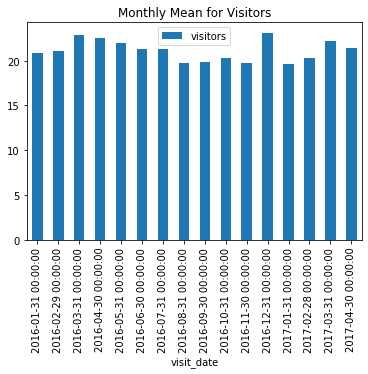

In [62]:
plt.figure(figsize=(15,8))
main_df[['visitors']].resample('M').mean().plot(kind='bar')
plt.title('Monthly Mean for Visitors')
plt.show()

In [63]:
# 샘플링 -가게 id 하나 가져와서 시각화
first_sample = main_df['air_store_id'][0]

In [64]:
main_df.loc[main_df['air_store_id'] == first_sample]

,air_store_id,visitors,dayofweek,year,month,day,air_genre_name,air_area_name,latitude,longitude,min_visitors,max_visitors,mean_visitors,count_visitors,reserve_datetime_diff_ar,reserve_visitors_ar,reserve_datetime_diff_hr,reserve_visitors_hr,holiday_flg
visit_date,,,,,,,,,,,,,,,,,,,
2016-01-13,air_ba937bf13d40fb24,25,2,2016,1,13,4.0,62.0,35.658068,139.751599,7.0,57.0,23.843750,64.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-14,air_ba937bf13d40fb24,32,3,2016,1,14,4.0,62.0,35.658068,139.751599,2.0,54.0,20.292308,65.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-15,air_ba937bf13d40fb24,29,4,2016,1,15,4.0,62.0,35.658068,139.751599,4.0,61.0,34.738462,65.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-16,air_ba937bf13d40fb24,22,5,2016,1,16,4.0,62.0,35.658068,139.751599,6.0,53.0,27.651515,66.0,-1.0,-1.0,-1.0,-1.0,0
2016-01-18,air_ba937bf13d40fb24,6,0,2016,1,18,4.0,62.0,35.658068,139.751599,2.0,34.0,13.754386,57.0,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-18,air_ba937bf13d40fb24,11,1,2017,4,18,4.0,62.0,35.658068,139.751599,5.0,35.0,18.580645,62.0,-1.0,-1.0,-1.0,-1.0,0
2017-04-19,air_ba937bf13d40fb24,11,2,2017,4,19,4.0,62.0,35.658068,139.751599,7.0,57.0,23.843750,64.0,-1.0,-1.0,-1.0,-1.0,0
2017-04-20,air_ba937bf13d40fb24,14,3,2017,4,20,4.0,62.0,35.658068,139.751599,2.0,54.0,20.292308,65.0,-1.0,-1.0,-1.0,-1.0,0


In [65]:
# 391일 동안 방문한 visitors -> main
visitors_of_sample = main_df.loc[main_df['air_store_id'] == first_sample]['visitors'].values

In [66]:
main_df.index[:391]

DatetimeIndex(['2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21',
               '2016-01-22', '2016-01-23',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', name='visit_date', length=391, freq=None)

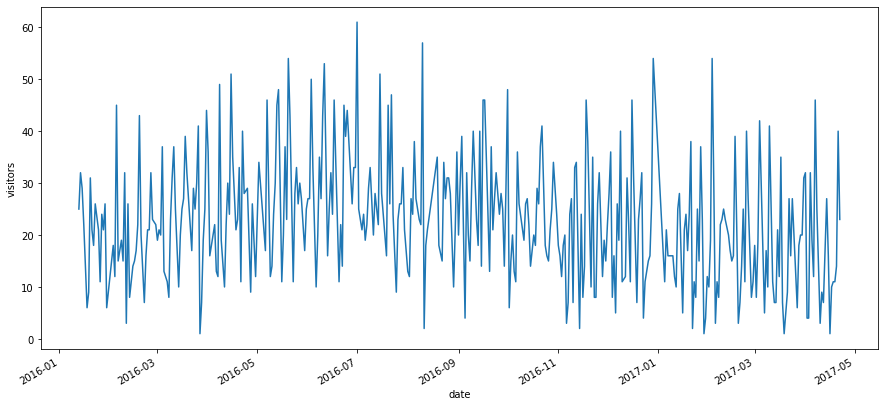

In [67]:
plt.figure(figsize=(15,7))
main_df['visitors'][:391].plot()
plt.xlabel("date")
plt.ylabel("visitors")
plt.show()

### 5. 범주형 변수 인코딩

- 위에서 진행한 내용으로 대체

### 6. 공간데이터 시각화

In [68]:
# matplotlib basemap toolkit을 설치합니다.
!pip install libgeos-3.5.0
!pip install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

ERROR: Could not find a version that satisfies the requirement libgeos-3.5.0 (from versions: none)
ERROR: No matching distribution found for libgeos-3.5.0
ERROR: Could not find a version that satisfies the requirement libgeos-dev (from versions: none)
ERROR: No matching distribution found for libgeos-dev
     \ 133.1 MB 1.8 MB/s
     |████████████████████████████████| 6.6 MB 8.1 MB/s 
     |████████████████████████████████| 219 kB 70.3 MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759597 sha256=ec46a851553411a084a04ae49faedfa4b2358517179aab45aa8cb0b4077a3cdb
  Stored in directory: /tmp/pip-ephem-wheel-cache-xybqxkak/wheels/98/1a/9d/de6aa4dee52d726996be77bb4a65cf03865288bfc35e5b24d8
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=94f53951c8e6b334c853eae5ba8d7013153c36bb3ea25b335f072dad3497114f
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Su

In [69]:
# air system과 hpg system 전체 가게들의 위도와 경도 정보를 활용해 지역 분포를 살펴봅니다.
# 일본의 지역구를 크게 10개 클러스터로 나누었습니다.
# https://www.kaggle.com/asindico/a-japanese-journey 커널을 참고했습니다.(지역별 분포를 잘 시각화한 것을 참고했습니다.)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(main_df[['longitude','latitude']])

main_df_copy = main_df.copy()
main_df_copy['cluster'] = kmeans.predict(main_df[['longitude','latitude']])

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
m = Basemap(projection='aeqd',width=2000000,height=2000000, lat_0=37.5, lon_0=138.2)

cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]
cm = plt.get_cmap('gist_rainbow')
colors = [cm(2.*i/10) for i in range(10)]
colored = [colors[k] for k in main_df_copy['cluster']]
f,axa = plt.subplots(1,1,figsize=(15,16))
m.drawcoastlines()
m.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)
m.scatter(main_df_copy.longitude.values,main_df_copy.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
m.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)
plt.setp(axa.get_yticklabels(), visible=True)

# 지역구별로 0-9 까지 주석을 달아줍니다.
plt.annotate('Fukuoka', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)
plt.annotate('Hiroshima', xy=(0.2, 0.36), xycoords='axes fraction',fontsize=20)
plt.annotate('Osaka', xy=(0.40, 0.30), xycoords='axes fraction',fontsize=20)

plt.annotate('Tokyo', xy=(0.60, 0.4), xycoords='axes fraction',fontsize=20)
plt.annotate('Shizuoka', xy=(0.50, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Niigata', xy=(0.48, 0.54), xycoords='axes fraction',fontsize=20)
plt.annotate('Fukushima', xy=(0.62, 0.54), xycoords='axes fraction',fontsize=20)
plt.annotate('Hokkaido', xy=(0.7, 0.74), xycoords='axes fraction',fontsize=20)


for i in range(len(cx)):
    xpt,ypt = m(cx[i],cy[i])
    plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)
plt.show()

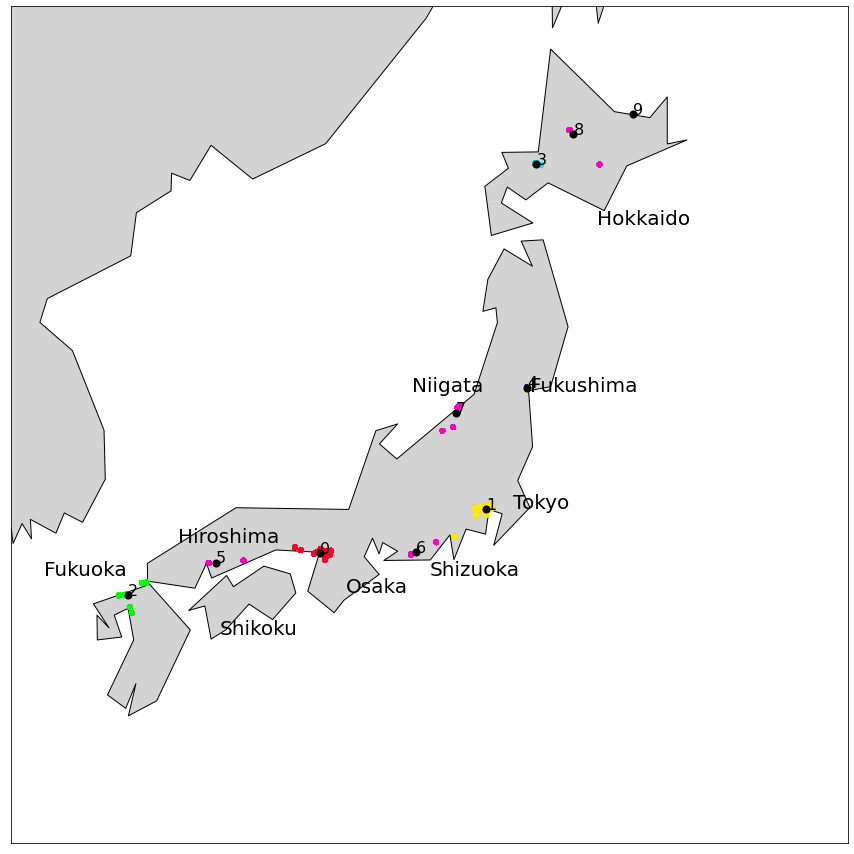

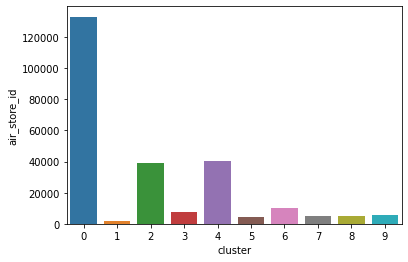

In [71]:
# cluster 별 상점 개수를 히스토그램으로 그려봅니다.
# training dataset인 main_df에는 도쿄에 많은 상점들이 있습니다.
hist_clust = main_df_copy.groupby(['cluster'],as_index=False).count()
sns.barplot(x=hist_clust.cluster,y=hist_clust.air_store_id)
plt.show()

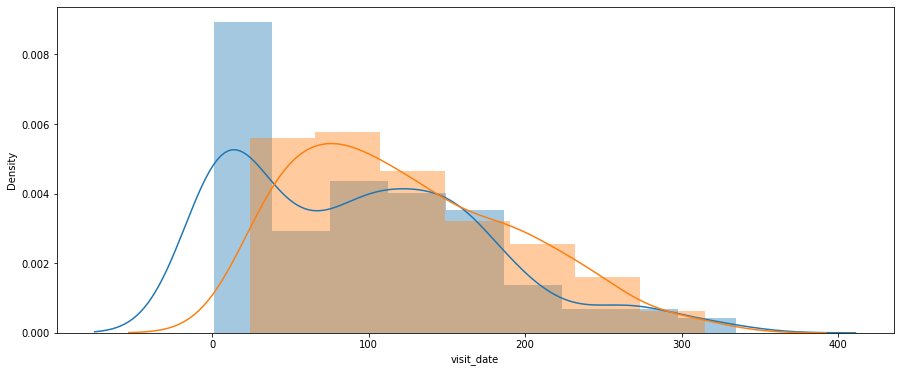

In [72]:
# 방문날짜별 air와 hpg 의 데이터 분포를 살펴봅니다. (하늘색: air, 오렌지: hpg)
f,ax = plt.subplots(1,1,figsize=(15,6))
airhist = ar_df.groupby(['air_store_id'],as_index=False).count()
sns.distplot(airhist.visit_date)
hpghist = hr_df.groupby(['air_store_id'],as_index=False).count()
sns.distplot(hpghist.visit_date)
plt.show()

# 4. Modeling

### 성능지표

Submissions are evaluated on the root mean squared logarithmic error.
The RMSLE is calculated as

$
rmsle = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(p_{i}+1)-log(a_{i}+1))^2}
$

\\(n\\) is the total number of observations
\\(p_i\\) is your prediction of visitors
\\(a_i\\) is the actual number of visitors
\\(\log\\) is the natural logarithm of \\(x\\)

### Submission File

For every store and date combination in the test set, submission files should contain two columns: id and visitors.  The id is formed by concatenating the air_store_id and visit_date with an underscore. The file should contain a header and have the following format:

```
id,visitors
air_00a91d42b08b08d9_2017-04-23,0  
air_00a91d42b08b08d9_2017-04-24,0  
air_00a91d42b08b08d9_2017-04-25,0  
etc.
```

### Modeling

1차 모델링
- Baseline Feature를 사용해 LGBM 모델을 사용한 Visitors 예측 

결과: 가장 좋은 성능을 보여주었다.

2차 모델링
- Baseline Feature를 사용해 Ensemble 모델을 사용한 Visitors 예측 
    - 0.3 * AverageModel - (GradientBoosting + RandomForest) 
    -  0.3 * Xgboost
    - 0.4 * LightGBM

결과: 트리 모델이 생각보다 좋지 않았고 LightGBM 모델이 가장 좋은 성능을 보였는데 AverageModel과 Xgboost 성능이 좋지 않았기 때문에 Ensemble을 선택할 이유가 없어서 최종적으로 LightGBM 모델을 선택하였다.

3차 모델링
- Feature Engineering을 통해 전처리 이후 LightGBM 모델을 사용하여 Visitors 예측

결과: visitors의 이상치 값을 max값으로 변환 하고 visitors 벡터를 Log transformation 후 통계량 계산한 값을 예측에 사용하였다. 가장 좋은 성능을 보여준 1차 모델을 사용해서 제출한 결과는 1차 모델링보다 좋지 않았다.

결론: Baseline Feature 선택 + LGBM 모델





```
submission_LGBM1 : baseline + stores , lgbm
0.54906 0.49335
submission_LGBM2:  baseline + stores , lgbm
0.53456 0.49591
submission_ensemble: baseline ,  0.3 * Average(GBoost + RandomForest)  + 0.4 * lgbm + 0.3 * xgb
0.55122 0.51360
submission_more_feat1: baseline + [결측치 대체] + stores , lgbm
0.59594 0.57691
submisson_more_feat2: baseline + [is_friday_or_weekend] + 통계량 추가 , stores, lgbm
0.53508 0.49389
submisson_more_feat3: baseline 수정(visitors 이상치 제거, log변환 후 통계량 계산) + stores + lgbm
0.54836 0.50303
```

|Public|Private|
|:-----:|:-----:|

In [73]:
model_list = [
    'submission_lgbm1', 'submisson_lgbm2', 'submission_ensemble', 'submission_feat1', 'submission_feat2', 'submission_feat3'
]
score_list = {'public', 'private'}
scores = np.array([
    [0.54906, 0.49335],
    [0.53456, 0.49591],
    [0.55122, 0.51360],
    [0.59594, 0.57691],
    [0.53508, 0.49389],
    [0.54836, 0.50303]]
)

score_df = pd.DataFrame(scores, index=model_list, columns=score_list)
score_df.style.highlight_min(color="blue")

,private,public
submission_lgbm1,0.549060,0.493350
submisson_lgbm2,0.534560,0.495910
submission_ensemble,0.551220,0.513600
submission_feat1,0.595940,0.576910
submission_feat2,0.535080,0.493890
submission_feat3,0.548360,0.503030


In [76]:
train = copy_main.copy()

train_x = train.drop(['air_store_id', 'visit_date', 'visitors', 'reserve_datetime_diff_ar','reserve_datetime_diff_hr','reserve_visitors_ar','reserve_visitors_hr'], axis=1)
train_y = np.log1p(train['visitors'].values)
test_x = test_df.drop(['id','air_store_id', 'visit_date', 'visitors','reserve_datetime_diff_ar','reserve_datetime_diff_hr','reserve_visitors_ar','reserve_visitors_hr'], axis=1)
print(train_x.shape, train_y.shape, test_x.shape)

(252108, 13) (252108,) (32019, 13)


In [77]:
%%time
lgbm = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=60,
    learning_rate=0.01,
    n_estimators=10000)

lgbm.fit(train_x, train_y, eval_metric='rmse', verbose=100)
y_pred = lgbm.predict(test_x)
test_df['visitors'] = np.expm1(y_pred)
test_df.head()

CPU times: user 4min 2s, sys: 2.7 s, total: 4min 4s
Wall time: 2min 4s


In [78]:
submission = test_df[["id","visitors"]]
submission.to_csv(os.path.join(data_path,"submission.csv"), index=False)
display(submission)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.649667
1,air_00a91d42b08b08d9_2017-04-24,21.888844
2,air_00a91d42b08b08d9_2017-04-25,25.971626
3,air_00a91d42b08b08d9_2017-04-26,28.936810
4,air_00a91d42b08b08d9_2017-04-27,31.877291
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.873019
32015,air_fff68b929994bfbd_2017-05-28,3.337662
32016,air_fff68b929994bfbd_2017-05-29,3.595270
32017,air_fff68b929994bfbd_2017-05-30,4.417279


# 5. Retrospective 회고
- 베이스라인 코드에서 이것저것 시도를 해보았는데, 베이스라인의 성능이 가장 좋았다.

- 전처리 과정에서는, 우선 training dataset과 test 셋으로 분리해서 feature들을 결합시켜주었다. 방문날짜, 년, 월, 일, 점포 id, 점포 종류, 위도, 경도 등 방문자 수에 영향을 주는 피처들로 전처리를 해주었다.

- 결측치에서는 "reserve_datetime_diff"와 "reserve_visitors" 결측치가 많은 항목들을 어떻게 처리해줄지가 고민이었다. 방문 손님 중 예약을 한 손님에 대한 데이터가 적었기 때문이다. 이상치는 적절하게 처리해주고자 했지만, 오히려 이상치를 변환해준 것이 성능이 떨어졌다.

- 범주형 데이터 처리에는 'label encoder'가 적절했다. air_genre_name, air_area_name 두 변수는 범주형인데 'ordinal'하지 않은 'nominal'변수이다. 하지만 ordinal 변수에 사용되는 label encoder 를 사용한 것이 base n encoder(원핫인코딩과 유사한데 차수를 줄여주는 인코딩 기법, nominal 변수에 사용) 보다 성능이 좋다. 이론과 실제는 다르다는 것을 느낄 수 있었다.

- 데이터 시각화를 진행하면서는, 피처들 중 "방문날짜(visit_date)", "방문요일", "위도","경도", "휴일 여부" 등이 방문자수 예측에 영향을 주는 변수임을 알 수 있었다. 그에 비해 "reserve_datetime_diff"는 영향을 미치는 정도가 낮은 것 같았다.

- 모델링 파트에서는 기준이 되는 Baseline 모델을 선정하여 feature engineering을 통해 성능을 개선하고자 하였지만 다방면으로 feature를 추가하거나 값을 변경할 수록 성능이 떨어지는 문제가 발생하였다. visitors를 예측하는데 중요한 특성을 생성하고 전처리하는 부분을 개선해야 할 것 같고, 머신러닝 모델 이외에도 TimeSeries 데이터 분석에 사용되는 ARIMA 모델, 딥러닝의 LSTM의 성능도 확인해보고 싶었지만 다양한 시도를 하기에는 시간이 많이 부족했던 것 같다.

- LightGBM 파라미터 튜닝을 하지 못하고 마무리 했는데 일단 짧은 시간에 Submission이 가능한 단순한 모델로 테스트하였고, 나중에 Optimal Parameter Search와 TimeSeriesSplit Cross Validation을 통해서 조금이라도 성능을 향상시킬 수 있을 것 같다.


In [ ]:
# 시도
# 이상치 masking
'''
def outliers_detect(feat):
    return (feat - feat.mean()) > 1.96 * feat.std()

def outlier_to_max_val(feat):
    outlier_mask = outliers_conf_interval(feat)
    max_val = feat[~outlier_mask].max()
    feat[outlier_mask] = max_val
    return feat

stores = main_df.groupby('air_store_id')
main_df['is_outlier'] = stores.apply(lambda x: outliers_detect(x['visitors'])).values
main_df['visitors_max'] = stores.apply(lambda x: outlier_to_max_val(x['visitors'])).values
main_df['visitors_log_transformed'] = np.log1p(main_df['visitors_transformed'])

min_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors_log_transformed'].agg('min').rename(columns={
    'visitors_log_transformed' : 'min_log_visitors'})
max_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors_log_transformed'].agg('max').rename(columns={
    'visitors_log_transformed' : 'max_log_visitors'})
mean_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors_log_transformed'].agg('mean').rename(columns={
    'visitors_log_transformed' : 'mean_log_visitors'})
median_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors_log_transformed'].agg('median').rename(columns={
    'visitors_log_transformed' : 'median_log_visitors'})
std_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors_log_transformed'].agg('std').rename(columns={
    'visitors_log_transformed' : 'std_log_visitors'})
count_df = main_df.groupby(['air_store_id', 'dayofweek'], as_index=False)['visitors_log_transformed'].agg('count').rename(columns={
    'visitors_log_transformed' : 'count_log_visitors'})

min_df.head()
'''

# di_df['is_friday_or_weekend'] = di_df['dayofweek'].isin([4,5,6]).astype(int)